## NOAA
NOAA provides observational readings from around the world. It collects this information from the various weather stations in each region. This means the quality depends on the reporting by the local stations. There is a measure of quality which is applied by NOAA which I need to dig into further. However, assuming you know a station provides quality data, you can use this data safely. 

Not all data may have been reported for all time. So check different samples in different years to ensure its presence. 

### Daily Summary (GSOD) vs Hourly (ISH)
There are two main types of data provided by NOAA. One is Global Surface Summary of the Day ([GSOD](https://data.noaa.gov/dataset/global-surface-summary-of-the-day-gsod)). As the name suggest, it is a summary for the entire days readings and can be retrieved from [here](https://www.ncdc.noaa.gov/isd/data-access). To get hourly observations (or more recently every 30 minutes) use the Integrated Surface Reporting Hourly ([ISH](https://gis.ncdc.noaa.gov/geoportal/catalog/search/resource/details.page?id=gov.noaa.ncdc:C00532)) datasets which can be accessed [here](https://www1.ncdc.noaa.gov/pub/data/noaa/). 

### Stations 
The list of stations can be found [here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt). The station Id = USAF + WBAN. The WBAN is a default for the majority of stations in Europe. The list of stations also displays when it started and stopped recording data. 

Barcelona Station Id is 081810-99999

In Barcelona there appears to be two different stations, one that reports on the hour and one on the half hour. They are both included when reading the station id.

The main airport observation location is 41.297, 2.078. However a secondary airport observation location is 41.293, 2.07. There are however substantial differences in the reported measurements. 

### APIs 
There are a lot of very fragmented ways to access this data and it took some time to find the best. Currently we download the yearly files and work directly against these. There are more RESTful APIs but they are very difficult to use and much much slower.

In [30]:
%matplotlib inline

import seaborn as sns
sns.set_color_codes()

In [7]:
# import ish_parser library
from ish_parser import ish_parser

import httplib2
from cStringIO import StringIO
import gzip

URL_TEMPLATE = "https://www1.ncdc.noaa.gov/pub/data/noaa/{year}/{usaf}-{wban}-{year}.gz"

def read_ish(usaf, wban, year):
    url = URL_TEMPLATE.format(year=year, usaf=usaf, wban=wban)
    h = httplib2.Http()
    h.ignore_etag = True
    resp, content = h.request(url)
    if resp.status != 200:
        return
    with gzip.GzipFile(fileobj=StringIO(content)) as gz:
        return bytes.decode(gz.read())

content = read_ish("081810", "99999", "2017")
print("done reading")

wf = ish_parser()
wf.loads(content)

print("done parsing")

# get the list of all reports
reports = wf.get_reports()
print len(reports)

report = reports[-2]
print(report.formatted())

done reading
done parsing
6648

Weather Station: 081810 (41.297, 2.078)
Elevation: 4 m
Time: 2017-04-02 21:30:00+00:00 UTC
Air Temperature: 12.0 C (53.6 F)
Wind Speed: 3.1 m/s (6.9345 mph)
Wind Direction: 310
Present Weather Obs: None
Precipitation: None
Cloud Coverage: [{'cloud_type': Altocumulus Mammatus (Acmam), 'base_height': 762, 'coverage': 02}] oktas
Cloud Summation: None
Solar Irradiance: None 
    


In [57]:
import pandas as pd

df = pd.DataFrame({'timestamp': [report.datetime for report in reports], 
              'wind_direction': [report.wind_direction.get_numeric() for report in reports],
              'wind_speed': [report.wind_speed.get_numeric() for report in reports]})

df = df.set_index('timestamp')

df.tail(10)

,timestamp,wind_direction,wind_speed
6638,2017-04-02 18:30:00+00:00,300.0,3.6
6639,2017-04-02 19:00:00+00:00,40.0,1.5
6640,2017-04-02 19:00:00+00:00,230.0,2.6
6641,2017-04-02 19:30:00+00:00,350.0,3.1
6642,2017-04-02 20:00:00+00:00,350.0,2.1
6643,2017-04-02 20:00:00+00:00,20.0,2.6
6644,2017-04-02 20:30:00+00:00,20.0,2.1
6645,2017-04-02 21:00:00+00:00,360.0,2.6
6646,2017-04-02 21:00:00+00:00,320.0,2.1
6647,2017-04-02 21:30:00+00:00,310.0,3.1


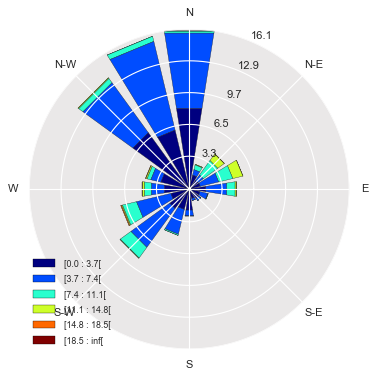

In [67]:
from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

def get_weather_between(df, start, end):
    return df.query('timestamp >= {} and timestamp <= {}'.format(start, end))

jan_df = get_weather_between(df, '20170401', '20170402')

wd = df['wind_direction']
ws = df['wind_speed']

ax = WindroseAxes.from_ax()
ax.set_axis_bgcolor('#eae8e8')
#ax.contourf(wd, ws, bins=np.arange(0, 8, 1), cmap=cm.hot)
ax.bar(wd, ws, normed=True, opening=0.8)
ax.set_legend()
plt.gcf().set_size_inches(5, 5)

In [35]:
report = reports[-3]
print(report.formatted())


Weather Station: 081810 (41.293, 2.07)
Elevation: 4 m
Time: 2017-04-02 21:00:00+00:00 UTC
Air Temperature: 11.7 C (53.1 F)
Wind Speed: 2.6 m/s (5.816 mph)
Wind Direction: 360
Present Weather Obs: None
Precipitation: [{'hours': 3, 'depth': 0.3}]
Cloud Coverage: [{'cloud_type': 91, 'base_height': 99999, 'coverage': MISSING}, {'cloud_type': 90, 'base_height': 99999, 'coverage': MISSING}, {'cloud_type': Cloud not visible owing to darkness, fog,
           duststorm, sandstorm, or other analogous phenomena / sky obscured, 'base_height': 600, 'coverage': 01}] oktas
Cloud Summation: None
Solar Irradiance: None 
    
